In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import ignite.metrics
import ignite.contrib.handlers
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import librosa.display as ld
import pandas as pd
import noisereduce as nr
import soundfile as sf
import pickle

from torchinfo import summary
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Init

In [2]:
IMAGE_SIZE = 64
NUM_CLASSES = 36 # 26 + 10
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-1
EPOCHS = 1100

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cpu


### Pre-processing

In [4]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [5]:
AUDIO_FILE = '../dataset/Zoom/'
keys_s = '1234567890qwertyuiopasdfghjklzxcvbnm'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

for i, File in enumerate(keys):
    loc = AUDIO_FILE + File
    samples, sample_rate = librosa.load(loc, sr=None)
    #samples = samples[round(1*sample_rate):]
    strokes = []
    prom = 0.06
    step = 0.005
    while not len(strokes) == 25:
        strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
        if len(strokes) < 25:
            prom -= step
        if len(strokes) > 25:
            prom += step
        if prom <= 0:
            print('-- not possible for: ',File)
            break
        step = step*0.99
    label = [labels[i]]*len(strokes)
    data_dict['Key'] += label
    data_dict['File'] += strokes

df = pd.DataFrame(data_dict)
mapper = {}
counter = 0
for l in df['Key']:
    if not l in mapper:
        mapper[l] = counter
        counter += 1
df.replace({'Key': mapper}, inplace=True)

In [6]:
print("Sample Rate --> \n", sample_rate)
sr = sample_rate
print("-"*50)
print("data_frame.head() --> \n", df.head())
print("-"*50)
print("data_frame.info() --> \n", df.info())

Sample Rate --> 
 32000
--------------------------------------------------
data_frame.head() --> 
   Key                                               File
0   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
1   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
2   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
3   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
4   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
data_frame.info() --> 
 None


### Start Training

In [7]:
train, test = train_test_split(df, test_size=0.2)
print(len(train))
print(len(test))

720
180


In [8]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])

In [9]:
train_dataset = MyDataset(train, aug = aug)
val_dataset = MyDataset(test, transform = transform)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)

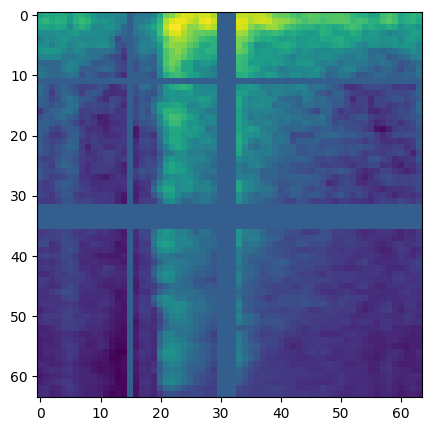

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(train_dataset[0][0][0], cmap='viridis')

In [11]:
result_dict = {'epochs':[], 'train_data_loss':[], "train_data_acc":[], 'val_data_acc':[], 'val_data_loss':[]}

### Model

In [12]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

class Partial:
    def __init__(self, module, *args, **kwargs):
        self.module = module
        self.args = args
        self.kwargs = kwargs

    def __call__(self, *args_c, **kwargs_c):
        return self.module(*args_c, *self.args, **kwargs_c, **self.kwargs)

class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x
    
class Residual(nn.Module):
    def __init__(self, *layers, shortcut=None):
        super().__init__()
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)
    
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                      groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        
def get_shortcut(in_channels, out_channels, stride):
    if (in_channels == out_channels and stride == 1):
        shortcut = nn.Identity()
    else:
        shortcut = nn.Conv2d(in_channels, out_channels, 1)

    if stride > 1:
        shortcut = nn.Sequential(nn.MaxPool2d(stride), shortcut)
    
    return shortcut

class SqueezeExciteBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.out_channels = channels
        channels_r = channels // reduction
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels_r, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(channels_r, channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return x * self.se(x)
    
class MBConv(Residual):
    def __init__(self, in_channels, out_channels, shape, kernel_size=3, stride=1, expansion_factor=4):
        mid_channels = in_channels * expansion_factor
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            ConvBlock(in_channels, mid_channels, 1), # Pointwise
            ConvBlock(mid_channels, mid_channels, kernel_size, stride=stride, groups=mid_channels), # Depthwise
            SqueezeExciteBlock(mid_channels),
            nn.Conv2d(mid_channels, out_channels, 1), # Pointwise
            shortcut = get_shortcut(in_channels, out_channels, stride)
        )

class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape, p_drop=0.):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5
        
        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)
        
        height, width = shape
        self.pos_enc = nn.Parameter(torch.randn(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))

        self.drop = nn.Dropout(p_drop)
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)
        
        att = keys.transpose(-2, -1) @ queries
        
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))
        
        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)
        
        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        out = self.drop(out)
        return out
    
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
    
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4, p_drop=0.):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1),
            nn.Dropout(p_drop)
        )

class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, head_channels, shape, stride=1, p_drop=0.):
        shape = (shape[0] // stride, shape[1] // stride)
        super().__init__(
            Residual(
                LayerNormChannels(in_channels),
                nn.MaxPool2d(stride) if stride > 1 else nn.Identity(),
                SelfAttention2d(in_channels, out_channels, head_channels, shape, p_drop=p_drop),
                shortcut = get_shortcut(in_channels, out_channels, stride)
            ),
            Residual(
                LayerNormChannels(out_channels),
                FeedForward(out_channels, out_channels, p_drop=p_drop)
            )
        )

class Stem(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3, stride=stride),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

class Head(nn.Sequential):
    def __init__(self, channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(channels, classes)
        )

class BlockStack(nn.Sequential):
    def __init__(self, num_blocks, shape, in_channels, out_channels, stride, block):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, shape=shape, stride=stride))
            shape = (shape[0] // stride, shape[1] // stride)
            in_channels = out_channels
            stride=1
        super().__init__(*layers)

class CoAtNet(nn.Sequential):
    def __init__(self, classes, image_size, head_channels, channel_list, num_blocks, strides=None,
                 in_channels=1, trans_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * len(num_blocks)
        
        block_list = [MBConv,    # S1
                      MBConv,    # S2
                      Partial(TransformerBlock, head_channels, p_drop=trans_p_drop), # S3
                      Partial(TransformerBlock, head_channels, p_drop=trans_p_drop)] # S4
        
        layers = [Stem(in_channels, channel_list[0], strides[0])] # S0
        in_channels = channel_list[0]
        
        shape = (image_size, image_size)
        for num, out_channels, stride, block in zip(num_blocks, channel_list[1:], strides[1:], block_list):
            layers.append(BlockStack(num, shape, in_channels, out_channels, stride, block))
            shape = (shape[0] // stride, shape[1] // stride)
            in_channels = out_channels
            
        layers.append(Head(in_channels, classes, p_drop=head_p_drop))
        super().__init__(*layers)

In [13]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

def print_res():
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("train loss")
    
    plt.plot(list(result_dict['train_data_loss']))
    plt.plot(list(result_dict['val_data_loss']))
    plt.legend(["train loss", "val loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.plot(list(result_dict['train_data_acc']))
    plt.plot(list(result_dict['val_data_acc']))
    plt.legend(["train acc", "val acc"], loc =  "best")
    plt.show()

In [14]:
MODEL_PATH = "CoAtNet_Zoom_36.pkl" 

model = CoAtNet(NUM_CLASSES, IMAGE_SIZE, head_channels=32, channel_list=[64, 64, 128, 256, 512],
                num_blocks=[2, 2, 2, 2, 2], strides=[1, 1, 2, 2, 2],
                trans_p_drop=0.3, head_p_drop=0.3)
model.to(DEVICE)
model.apply(init_linear)

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CoAtNet(
  (0): Stem(
    (0): ConvBlock(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): BlockStack(
    (0): MBConv(
      (shortcut): Identity()
      (residual): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU(approximate='none')
        (2): ConvBlock(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (3): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0

### Training

In [15]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        print("val_loss, best_loss", val_loss, self.best_loss)
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [16]:
def train_model():
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, learning_rate=1e-6, weight_decay=WEIGHT_DECAY)
    lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                                 steps_per_epoch=len(train_loader), epochs=EPOCHS)

    num_epochs = EPOCHS
    device = DEVICE
    early_stopping = EarlyStopping(patience=45, min_delta=0)

    for epoch in range(num_epochs):
        result_dict['epochs'].append(epoch)
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        result_dict['train_data_loss'].append(loss.item())
        result_dict['train_data_acc'].append(correct/total)

        # Validation
        if (epoch + 1) % 1 == 0:
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                print(f"Validation Accuracy: {correct/total}")
                result_dict['val_data_loss'].append(loss.item())
                result_dict['val_data_acc'].append(correct/total)

        if (epoch + 1) % 50 == 0:
            print_res()
        
        # early stopping
        early_stopping(loss.item())
        if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            torch.save(model.state_dict(), MODEL_PATH)
            print("model has been saved at path:", MODEL_PATH)
            break

In [17]:
train_model()

KeyboardInterrupt: 